In [159]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../system')
import system

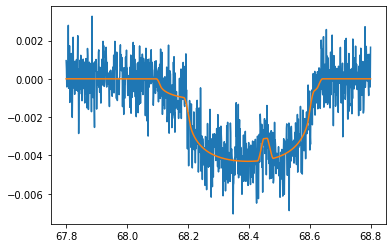

In [185]:
t = np.linspace(67.8, 68.8, 1000)

ap = 1.0
t0p = 0.2
ep = 0.2
Pp = 365
wp = 0.0 * np.pi / 180
ip = 90.0 * np.pi / 180

am = 0.007
t0m = -1.2
em = 0.1
Pm = 3
Om = 0.0 * np.pi / 180
wm = 90 * np.pi / 180
im = 90.0 * np.pi / 180
mm = 0.01

moon = system.moon(0.03, am, t0m, em, Pm, Om, wm, im, mm)
planet = system.planet(0.05, ap, t0p, ep, Pp, wp, ip)
star = system.star(0.4, 0.5)

sys = system.system(star, planet, moon)
sys.compute(t, grad=True)

lctrue = sys.lightcurve()
y = lctrue + np.random.randn(len(t)) * 0.001
plt.plot(t, y)
plt.plot(t, lctrue)

init_params = [0.001, 0.05, 0.03, 0.4, 0.5, ap, t0p, ep, Pp, wp, ip, am, t0m, em, Pm, Om, wm, im, mm]

In [186]:
def log_prior(args):
    
    sigma, rp, rm, u1, u2, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm = args
    
    if (mm < 1 and am < ap and 0 <= ep <= 1 and 0 <= em <= 1 and rm < rp and 
        u1 + u2 < 1 and u1 > 0 and u1 + 2 * u2 > 0):
        return 0.0
    return - np.inf

def log_like(args, y):
    
    sigma, rp, rm, u1, u2, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm = args
    moon = system.moon(rm, am, tm, em, pm, om, wm, im, mm)
    planet = system.planet(rp, ap, tp, ep, pp, wp, ip)
    star = system.star(u1, u2)
    sys = system.system(star, planet, moon)
    sys.compute(t, grad=False)
    return sys.loglike(y, sigma)

def log_prob(args, y):
    lp = log_prior(args)
    ll = log_like(args, y)
    if np.isfinite(ll):
        return lp + ll
    else:
        return -np.inf

In [187]:
from scipy.optimize import minimize 

nll = lambda *args: -log_like(*args)
soln = minimize(nll, init_params, args=(y))

In [188]:
import emcee

#pos = soln.x + 1e-4 * np.random.randn(50, len(soln.x))
pos = init_params + 1e-4 * np.random.randn(50, len(init_params))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(y,)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [02:29<00:00, 33.41it/s]


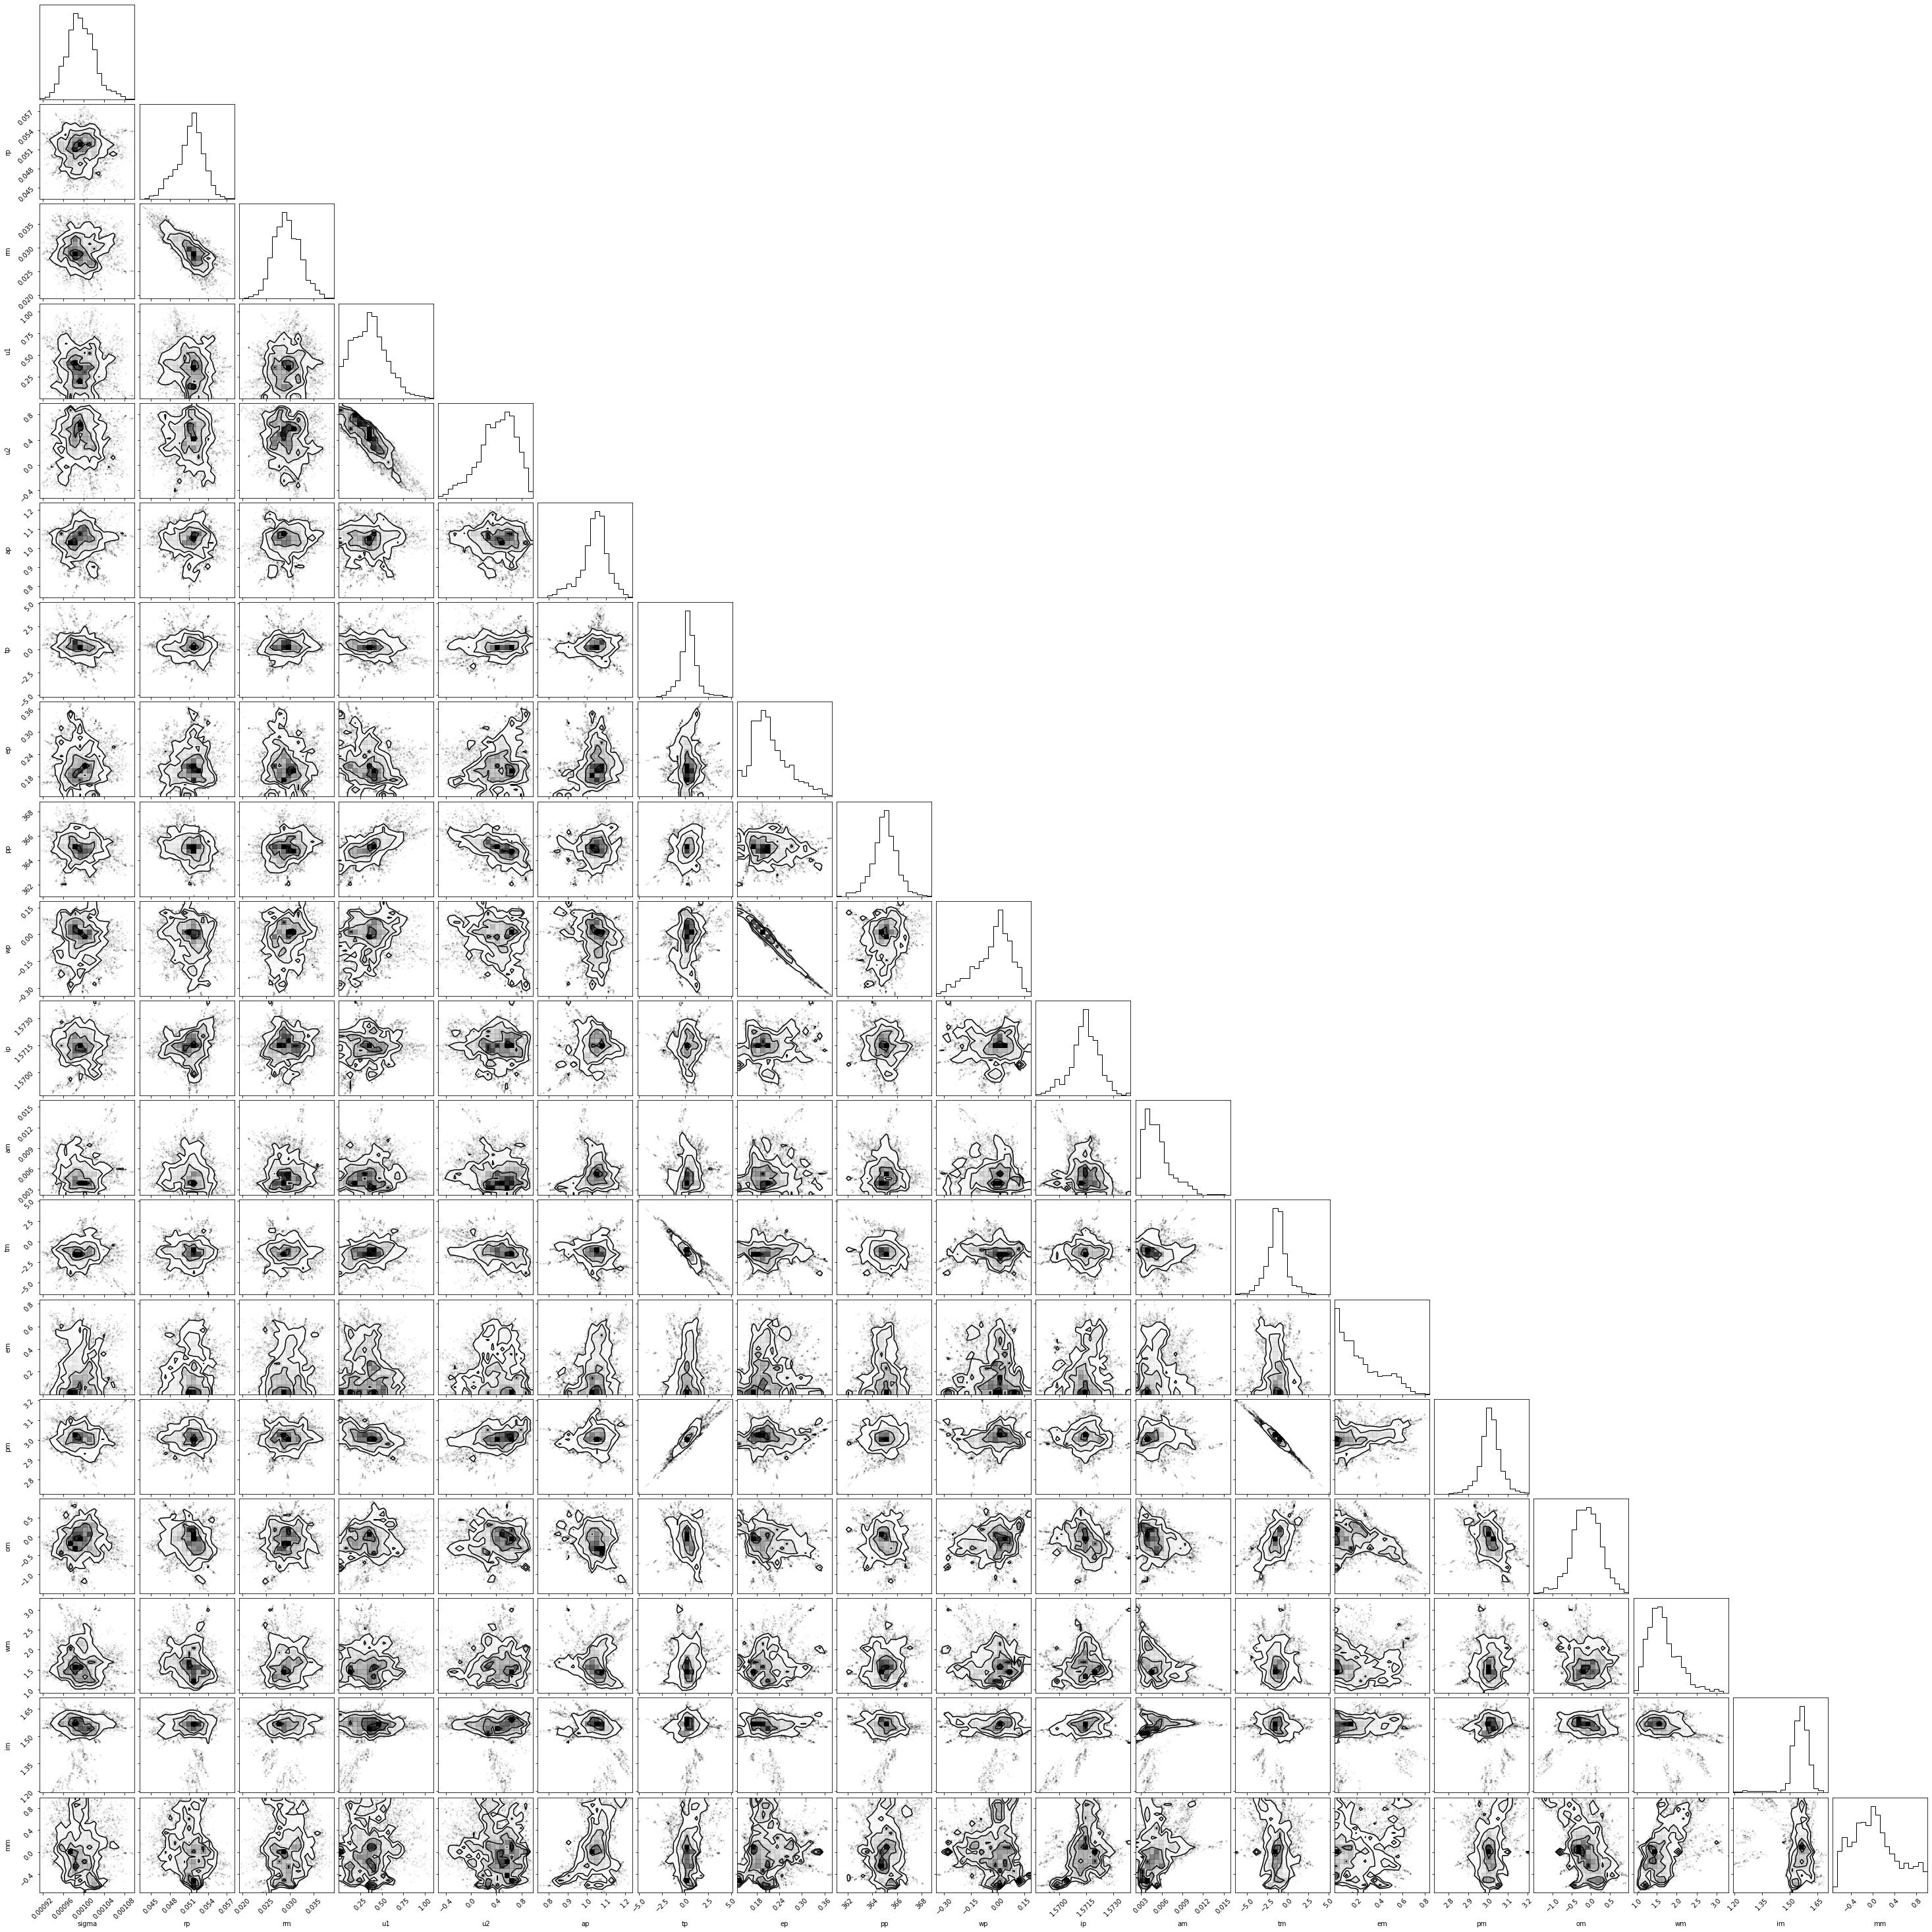

In [190]:
import corner

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=['sigma', 'rp', 'rm', 'u1', 'u2', 'ap', 'tp', 'ep', 'pp', 'wp', 'ip', 'am', 'tm', 'em', 'pm', 'om', 'wm', 'im', 'mm']);

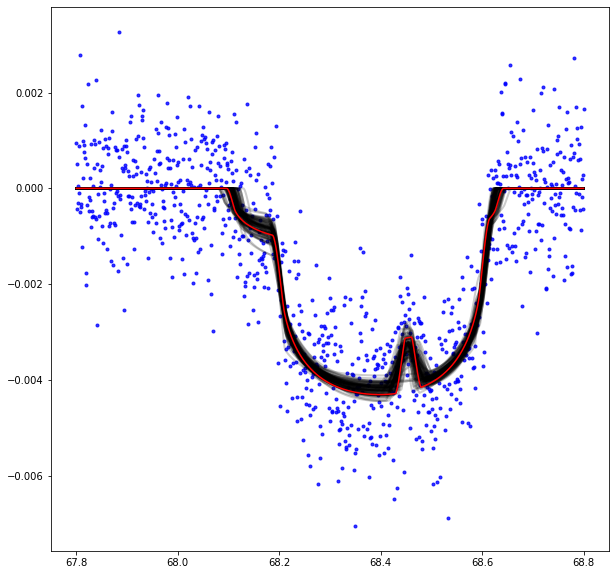

In [191]:
n = 100
inds = np.random.randint(len(flat_samples), size=n)
samps = flat_samples[inds]

def getlc(*args):
    _, rp, rm, u1, u2, ap, t0p, ep, Pp, wp, ip, am, t0m, em, Pm, Om, wm, im, mm = args
    moon = system.moon(rm, am, t0m, em, Pm, Om, wm, im, mm)
    planet = system.planet(rp, ap, t0p, ep, Pp, wp, ip)
    star = system.star(u1, u2)

    sys = system.system(star, planet, moon)
    sys.compute(t, grad=False)
    return sys.lightcurve()


plt.figure(figsize=(10, 10))
plt.plot(t, y, '.', alpha=0.8, color='b')
for i in range(n):
    lc = getlc(*samps[i])
    plt.plot(t, lc, color='k', linewidth=2, alpha=0.2)
    
plt.plot(t, lctrue, color='r')